In [93]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [94]:
import torchvision
import torchvision.transforms as transforms
from PIL import Image

class NumpyToPIL(object):
    """Convert a numpy array to a PIL Image."""
    def __call__(self, numpy_array):
        # Check if the numpy array is in (H, W, C) format and is of type uint8
        if numpy_array.dtype == np.uint8:
            return Image.fromarray(numpy_array)
        # If the numpy array is normalized (float and possibly between 0 and 1), convert it properly
        return Image.fromarray((numpy_array * 255).astype(np.uint8))

# Update the transform pipeline to include the NumpyToPIL transformation
transform = transforms.Compose([
    NumpyToPIL(),  # Ensure numpy arrays are converted to PIL Images first
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomCrop(32, padding=4),  # Random cropping with padding
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random color jitter
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformations
    transforms.ToTensor(),  # Convert PIL image to tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize the images over average for cifar10 dataset
    transforms.RandomErasing(inplace=True)  # Apply random erasing
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


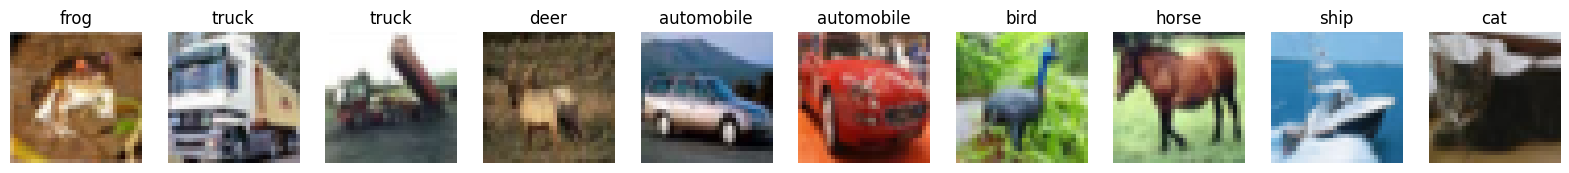

In [95]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = 'cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']
print(label_names)

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']
# Load one batch for demonstration (e.g., data_batch_2)
batch_2_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_2'))
train_images = np.concatenate((train_images, batch_2_dict[b'data']))
train_labels = np.concatenate((train_labels, batch_2_dict[b'labels']))
# Load one batch for demonstration (e.g., data_batch_3)
batch_3_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_3'))
train_images = np.concatenate((train_images, batch_3_dict[b'data']))
train_labels = np.concatenate((train_labels, batch_3_dict[b'labels']))
# Load one batch for demonstration (e.g., data_batch_4)
batch_4_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_4'))
train_images = np.concatenate((train_images, batch_4_dict[b'data']))
train_labels = np.concatenate((train_labels, batch_4_dict[b'labels']))
# Load one batch for demonstration (e.g., data_batch_5)
batch_5_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_5'))
train_images = np.concatenate((train_images, batch_5_dict[b'data']))
train_labels = np.concatenate((train_labels, batch_5_dict[b'labels']))

# Reshape the images
train_images = train_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

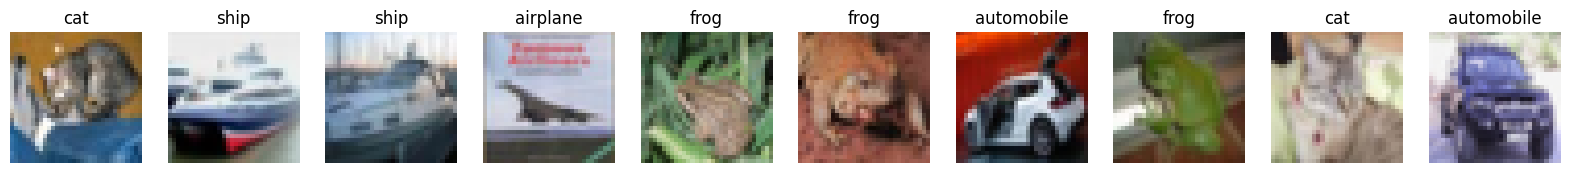

In [96]:
# Validation Set of images

validation_batch_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
validation_images = validation_batch_dict[b'data']
validation_labels = validation_batch_dict[b'labels']

# Reshape the images
validation_images = validation_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(validation_images[i])
    plt.title(label_names[validation_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

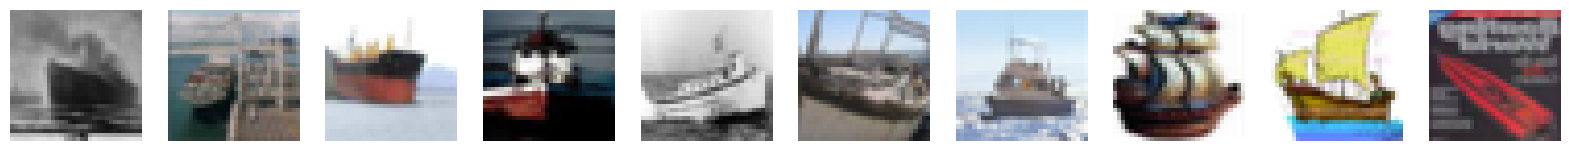

In [97]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

# Load the batch
cifar10_batch = load_cifar_batch('cifar_test_nolabels.pkl')

# Extract images
test_images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) 

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i])
    plt.axis('off')
plt.show()

In [98]:
# train_images = train_images[:100]
train_images = np.array([transform(image) for image in train_images])
train_data = list(zip(train_images, train_labels))
trainDataLoader = torch.utils.data.DataLoader(train_data,batch_size=128,shuffle=True)

validation_images = np.array([transform_test(image) for image in validation_images])
validation_data = list(zip(validation_images, validation_labels))
validationDataLoader = torch.utils.data.DataLoader(validation_data,batch_size=128,shuffle=False)

test_images = np.array([transform_test(image) for image in test_images])
testDataLoader = torch.utils.data.DataLoader(test_images,batch_size=128,shuffle=False)

In [99]:
'''ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_kernel_size=3, shortcut_kernel_size=1, drop=None, use_se=False, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=conv_kernel_size, stride=stride,
                               padding=conv_kernel_size // 2, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=conv_kernel_size, stride=1,
                               padding=conv_kernel_size // 2, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Optional Squeeze-and-Excitation block
        if use_se:
            self.se = SEBlock(planes)

        # Optional CBAM
        if use_cbam:
            self.cbam = CBAM(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=shortcut_kernel_size,
                          stride=stride, padding=shortcut_kernel_size // 2, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

        if drop:
            self.dropout = nn.Dropout(drop)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if hasattr(self, 'se'):
            out = self.se(out)
        if hasattr(self, 'cbam'):
            out = self.cbam(out)
        out += self.shortcut(identity)
        out = F.relu(out)
        if hasattr(self, 'dropout'):
            out = self.dropout(out)
        return out

class CBAM(nn.Module):
    """Implementation of the Convolutional Block Attention Module (CBAM)."""
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channels = channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        self.sigmoid_channel = nn.Sigmoid()
        self.conv_after_concat = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # Channel attention
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        scale = self.sigmoid_channel(out)
        x = x * scale

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        scale = torch.cat([avg_out, max_out], dim=1)
        scale = self.sigmoid_spatial(self.conv_after_concat(scale))
        x = x * scale
        
        return x

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    """
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)



class ResNet(nn.Module):
    def __init__(self, block, layers_config, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = layers_config[0]['planes']
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layers = nn.ModuleList()

        for config in layers_config:
            layer = self._make_layer(block, **config)
            self.layers.append(layer)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        final_planes = layers_config[-1]['planes'] * block.expansion
        self.linear = nn.Linear(final_planes, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, conv_kernel_size, shortcut_kernel_size, drop_rate, use_se, use_cbam):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_planes, planes, stride, conv_kernel_size, shortcut_kernel_size, drop_rate, use_se=use_se, use_cbam=use_cbam))
            self.in_planes = planes * block.expansion
            stride = 1  # Only the first block may have a stride different from 1
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        for layer in self.layers:
            x = layer(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x


def create_resnet():
    layers_config = [
        {'planes': 64,  'num_blocks': 3, 'stride': 1, 'conv_kernel_size': 3, 'shortcut_kernel_size': 1, 'drop_rate': 0.3, 'use_se': False, 'use_cbam': True},
        {'planes': 96,  'num_blocks': 3, 'stride': 2, 'conv_kernel_size': 3, 'shortcut_kernel_size': 1, 'drop_rate': 0.3, 'use_se': True,  'use_cbam': True},
        {'planes': 128, 'num_blocks': 3, 'stride': 2, 'conv_kernel_size': 3, 'shortcut_kernel_size': 1, 'drop_rate': 0.3, 'use_se': True,  'use_cbam': False},
        {'planes': 256, 'num_blocks': 3, 'stride': 2, 'conv_kernel_size': 3, 'shortcut_kernel_size': 1, 'drop_rate': 0.3, 'use_se': True,  'use_cbam': True}
    ]
    return ResNet(BasicBlock, layers_config, num_classes=10)


model = create_resnet() # Step 1: model generation
loss = torch.nn.CrossEntropyLoss() # Step 2: loss function
# Add weight decay for L2 regularization
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.9, weight_decay=5e-4)

In [100]:
model.train()
for p in model.parameters():
    if p.requires_grad:
        print(p.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([4, 64, 1, 1])
torch.Size([64, 4, 1, 1])
torch.Size([1, 2, 7, 7])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([4, 64, 1, 1])
torch.Size([64, 4, 1, 1])
torch.Size([1, 2, 7, 7])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([4, 64, 1, 1])
torch.Size([64, 4, 1, 1])
torch.Size([1, 2, 7, 7])
torch.Size([96, 64, 3, 3])
torch.Size([96])
torch.Size([96])
torch.Size([96, 96, 3, 3])
torch.Size([96])
torch.Size([96])
torch.Size([6, 96])
torch.Size([96, 6])
torch.Size([6, 96, 1, 1])
torch.Size([96, 6, 1, 1])
torch.Size([1, 2, 7, 7])
torch.Size([96, 64, 1, 1])
torch.Size([96])
torch.Size([96])
torch.Size([96, 96, 3, 3])
torch.Size([96])

In [101]:
import torchinfo

torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
ResNet                                             --
├─Conv2d: 1-1                                      1,728
├─BatchNorm2d: 1-2                                 128
├─ModuleList: 1-3                                  --
│    └─Sequential: 2-1                             --
│    │    └─BasicBlock: 3-1                        74,594
│    │    └─BasicBlock: 3-2                        74,594
│    │    └─BasicBlock: 3-3                        74,594
│    └─Sequential: 2-2                             --
│    │    └─BasicBlock: 3-4                        147,362
│    │    └─BasicBlock: 3-5                        168,674
│    │    └─BasicBlock: 3-6                        168,674
│    └─Sequential: 2-3                             --
│    │    └─BasicBlock: 3-7                        273,152
│    │    └─BasicBlock: 3-8                        297,472
│    │    └─BasicBlock: 3-9                        297,472
│    └─Sequential: 2-4         

In [102]:
import torch

# Assuming `model`, `optimizer`, `loss`, `trainDataLoader`, and `validationDataLoader` are already defined.

# Ensure the model and data are on the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Initialize history tracking and set the best validation loss to a high value
train_loss_history = []
validation_loss_history = []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(15):
    train_loss = 0.0
    validation_loss = 0.0
  
    # Training Phase
    model.train()
    for i, data in enumerate(trainDataLoader):
        images, labels = data[0].to(device), data[1].to(device).long()  # Move data to the same device as model and ensure labels are Long
        optimizer.zero_grad()  # zero out any gradient values from the previous iteration
        predicted_output = model(images)  # forward propagation  
        fit = loss(predicted_output, labels)  # calculate our measure of goodness
        fit.backward()  # backpropagation
        optimizer.step()  # update the weights of our trainable parameters
        train_loss += fit.item()

    # Validation Phase
    model.eval()
    with torch.no_grad():  # Ensure no gradients are calculated for validation
        for i, data in enumerate(validationDataLoader):
            images, labels = data[0].to(device), data[1].to(device).long()
            predicted_output = model(images)
            fit = loss(predicted_output, labels)
            validation_loss += fit.item()

    # Calculate and Print Average Losses
    train_loss /= len(trainDataLoader)
    validation_loss /= len(validationDataLoader)
    train_loss_history.append(train_loss)
    validation_loss_history.append(validation_loss)
    print(f'Epoch {epoch}, Train loss: {train_loss:.4f}, Validation loss: {validation_loss:.4f}')

    # Check if the current validation loss is the best we've seen so far
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        best_model_state = model.state_dict()
        # Optionally, save the best model to a file
        torch.save(model.state_dict(), 'best_model.pth')

    # Update learning rate
    scheduler.step()  # Update the learning rate based on the scheduler

# After training, you can load the best model
model.load_state_dict(best_model_state)

Epoch 0, Train loss: 1.9384, Validation loss: 1.6521
Epoch 1, Train loss: 1.6634, Validation loss: 1.5588
Epoch 2, Train loss: 1.5164, Validation loss: 1.4119
Epoch 3, Train loss: 1.3996, Validation loss: 1.2469
Epoch 4, Train loss: 1.3087, Validation loss: 1.4034
Epoch 5, Train loss: 1.2378, Validation loss: 1.2031
Epoch 6, Train loss: 1.1747, Validation loss: 1.1629
Epoch 7, Train loss: 1.1137, Validation loss: 1.0584
Epoch 8, Train loss: 1.0520, Validation loss: 0.9045
Epoch 9, Train loss: 0.9982, Validation loss: 0.8691
Epoch 10, Train loss: 0.9450, Validation loss: 0.9008
Epoch 11, Train loss: 0.8789, Validation loss: 0.7481
Epoch 12, Train loss: 0.8162, Validation loss: 0.7106
Epoch 13, Train loss: 0.7581, Validation loss: 0.6773
Epoch 14, Train loss: 0.7193, Validation loss: 0.6374


<All keys matched successfully>

In [103]:
import csv
 
# field names
fields = ['ID', 'Labels']

# name of csv file
filename = "sample_output.csv"

model.eval()

# writing to csv file
with open(filename, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
 
    # writing the fields
    csvwriter.writerow(fields)

    for batch_num, data in enumerate(testDataLoader):
        images = data
        output = model(images)
        for batch_index, image in enumerate(output):
            idx = batch_num*128 + batch_index
            label = int(image.argmax())
            
            # writing the data rows
            
            csvwriter.writerow([idx, label])